In [64]:
import numpy as np
import pandas as pd
import math
import scipy as scp
import scipy.stats as ss
import matplotlib as mpl
import matplotlib.pyplot as plt


In [7]:
class Option_param():
    """
    Option class wants the option parameters:
    S0 = current stock price
    K = Strike price
    T = time to maturity
    
    exercise = European or American
    """
    def __init__(self, S0=100, K=100, T=1, payoff="call", exercise="European"):
        self.S0 = S0
        self.K = K
        self.T = T
        self.Delta = None
        self.Gamma = None
        self.Theta = None
        self.Vega = None
        self.Rho = None
        
        if (exercise=="European" or exercise=="American"):
            self.exercise = exercise
        else: 
            raise ValueError("invalid type. Set 'European' or 'American'")
        
        if (payoff=="call" or payoff=="put"):
            self.payoff = payoff
        else: 
            raise ValueError("invalid type. Set 'call' or 'put'")


In [8]:
class Diffusion_process():
    """
    Class for the diffusion process:
    r = continuously compounded risk-free interest rate (% p.a.)
    q = continuously compounded dividend yield (% p.a.)
    sig = volatility (% p.a.)
    """
    def __init__(self, r=0.1, q=0.0, sig=0.2):
        self.r = r
        if (q<0):
            raise ValueError("Dividend must be positive")
        else:
            self.q = q
            
        if (sig<=0):
            raise ValueError("sig must be positive")
        else:
            self.sig = sig

    def exp_RV(self, S0, T, N):
        W = ss.norm.rvs( (self.r-0.5*self.sig**2)*T , np.sqrt(T)*self.sig, N)
        S_T = S0 * np.exp(W)
        return S_T

In [9]:
class Option_pricer():
    
    def __init__(self, Option_info, Process_info ):
        """
        Process_info:  of type Diffusion_process. It contains (r,mu, sig) i.e.  interest rate, drift coefficient, diffusion coefficient
    
        Option_info:  of type Option_param. It contains (S0,K,T) i.e. current price, strike, maturity in years
        """
        self.r = Process_info.r           # interest rate
        self.q = Process_info.q
        self.sig = Process_info.sig       # diffusion coefficient
        self.S0 = Option_info.S0          # current price
        self.K = Option_info.K            # strike
        self.T = Option_info.T            # maturity in years
        self.exercise = Option_info.exercise
        self.payoff = Option_info.payoff
        
        
    def payoff_f(self, S):
        if self.payoff == "call":
            Payoff = np.maximum( S - self.K, 0 )
        elif self.payoff == "put":    
            Payoff = np.maximum( self.K - S, 0 )  
        return Payoff
    
    
    def Binomial_Tree(self, N=10000):
        dT = float(self.T) / N                             # Delta t
        u = np.exp(self.sig * np.sqrt(dT))                 # up factor
        d = 1.0 / u                                   # down factor 

        V = np.zeros(N+1)                             # initialize the price vector
        S_T = np.array( [(self.S0 * u**j * d**(N - j)) for j in range(N + 1)] )  # price S_T at time T

        a = np.exp((self.r - self.q ) * dT)    # risk free compound return
        p = (a - d)/ (u - d)  # risk neutral up probability
        q = 1.0 - p           # risk neutral down probability   

        if self.payoff =="call":
            V[:] = np.maximum(S_T-self.K, 0.0)
        elif self.payoff =="put":
            V[:] = np.maximum(self.K-S_T, 0.0)
        else: raise ValueError("invalid type. Set 'call' or 'put'")

        
        if self.exercise == "American":
            for i in range(N-1, -1, -1):
                V[:-1] = np.exp(-self.r*dT) * (p * V[1:] + q * V[:-1])    # the price vector is overwritten at each step
                S_T = S_T * u                    # it is a tricky way to obtain the price at the previous time step
                if self.payoff=="call":
                    V = np.maximum( V, S_T-self.K )
                elif self.payoff=="put":
                    V = np.maximum( V, self.K-S_T )

            return ("American", V[0])
            
        elif self.exercise == "European":
            for i in range(N-1, -1, -1):
                V[:-1] = np.exp(-self.r*dT) * (p * V[1:] + q * V[:-1])    # the price vector is overwritten at each step

            return ("European",  V[0])
        
        else: raise ValueError("invalid type. Set 'American' or 'European'")
    
    
    def Monte_Carlo_Simulation(self, N=10000, paths=10000, order=2):
        """
        Monte Carlo Simulation for pricing American options
        
        N = number of time steps
        paths = number of generated paths
        order = order of the polynomial for the regression 
        """
        dt = self.T/(N-1)          # time interval
        df = np.exp(-self.r * dt)  # discount factor per time time interval

        X0 = np.zeros((paths,1))
        increments = ss.norm.rvs(loc=(self.r - self.q - self.sig**2/2)*dt, scale=np.sqrt(dt)*self.sig, size=(paths,N-1))
        X = np.concatenate((X0,increments), axis=1).cumsum(1)
        S = self.S0 * np.exp(X)
        
        if self.exercise == "American":
            if self.payoff =="put":
                H = np.maximum(self.K - S, 0)   # intrinsic values for put option
                V = np.zeros_like(H)            # value matrix
                V[:,-1] = H[:,-1]

                # Valuation by Monte Carlo Simulation
                for t in range(N-2, 0, -1):
                    good_paths = H[:,t] > 0    
                    rg = np.polyfit( S[good_paths, t], V[good_paths, t+1] * df, order)    # polynomial regression
                    C = np.polyval( rg, S[good_paths,t] )                             # evaluation of regression  

                    exercise = np.zeros( len(good_paths), dtype=bool)
                    exercise[good_paths] = H[good_paths,t] > C

                    V[exercise,t] = H[exercise,t]
                    V[exercise,t+1:] = 0
                    discount_path = (V[:,t] == 0)
                    V[discount_path,t] = V[discount_path,t+1] * df

                V0 = np.mean(V[:,1]) * df  # 
                return ("American" , V0)

            elif self.payoff =="call":
                H = np.maximum(S - self.K, 0)   # intrinsic values for put option
                V = np.zeros_like(H)            # value matrix
                V[:,-1] = H[:,-1]

                # Valuation by Monte Carlo Simulation
                for t in range(N-2, 0, -1):
                    good_paths = H[:,t] > 0  
                    if t==N-2: type(good_paths)
                    rg = np.polyfit( S[good_paths, t], V[good_paths, t+1] * df, order)    # polynomial regression
                    C = np.polyval( rg, S[good_paths,t] )                             # evaluation of regression  

                    exercise = np.zeros( len(good_paths), dtype=bool)
                    exercise[good_paths] = H[good_paths,t] > C

                    V[exercise,t] = H[exercise,t]
                    V[exercise,t+1:] = 0
                    discount_path = (V[:,t] == 0)
                    V[discount_path,t] = V[discount_path,t+1] * df

                V0 = np.mean(V[:,1]) * df  # 
                return("American" , V0)

            else: raise ValueError("invalid type. Set 'call' or 'put'")
    
        elif self.exercise == "European":
            if self.payoff =="put":
                H = np.maximum(self.K - S, 0)   # intrinsic values for put option
                V = np.zeros_like(H)            # value matrix
                V[:,-1] = H[:,-1]

                # Valuation by Monte Carlo Simulation
                for t in range(N-2, 0, -1):
                    V[:,t] = V[:,t+1] * df

                V0 = np.mean(V[:,1]) * df  # 
                return("European" , V0)   

            elif self.payoff =="call":
                H = np.maximum(S - self.K, 0)   # intrinsic values for put option
                V = np.zeros_like(H)            # value matrix
                V[:,-1] = H[:,-1]

                # Valuation by Monte Carlo Simulation
                for t in range(N-2, 0, -1):
                    V[:,t] = V[:,t+1] * df

                V0 = np.mean(V[:,1]) * df  # 
                return("European" , V0)

            else: raise ValueError("invalid type. Set 'call' or 'put'")

        else: raise ValueError("invalid type. Set 'American' or 'European'")
    
    
    
    def Black_Scholes(self):
        """ Black Scholes closed formula:
            payoff: call or put.
            S0: float.    initial stock/index level.
            K: float strike price.
            T: float maturity (in year fractions).  
            r: float constant risk-free short rate.
            sigma: volatility factor in diffusion term. """
   
        d1 = (np.log(self.S0/self.K) + (self.r - self.q + self.sig**2 / 2) * self.T) / (self.sig * np.sqrt(self.T))
        d2 = (np.log(self.S0/self.K) + (self.r - self.q - self.sig**2 / 2) * self.T) / (self.sig * np.sqrt(self.T))

        if self.payoff=='call':
            return ("European", self.S0 * np.exp(-self.q * self.T) * ss.norm.cdf( d1 ) - self.K * np.exp(-self.r * self.T) * ss.norm.cdf( d2 ))
        elif self.payoff=='put':
            return ("European", self.K * np.exp(-self.r * self.T) * ss.norm.cdf( -d2 ) - self.S0 * np.exp(-self.q * self.T) * ss.norm.cdf( -d1 ))
        else:
            raise ValueError("invalid type. Set 'call' or 'put'")
            
            
            
    def plot(self): 
        
        if self.exercise == "European":
            fig, axs = plt.subplots(2, figsize=(10,10))
            fig.tight_layout(pad = 7)

            K = np.arange(self.K*0.1,self.K*1.9, self.K*0.1)
            if self.payoff == "call":
                payoff = np.array(np.maximum(self.S0-K, 0))
            if self.payoff == "put":
                payoff = np.array(np.maximum(K-self.S0, 0))
            axs[0].plot(K, payoff, label = "exercise price at S0")


            price = np.array([])
            for k in np.arange(self.K*0.1,self.K*1.9, self.K*0.1):
                opt_param = Option_param(S0=self.S0, K=k, T=self.T, exercise=self.exercise, payoff=self.payoff)
                diff_param = Diffusion_process(r=self.r, sig=self.sig)
                option = Option_pricer(opt_param, diff_param)
                price = np.append(price, option.Black_Scholes()[1])

            axs[0].plot(K, price, label = "Black_Scholes Pricing")
            axs[0].set_title("Spot price = " + str(self.S0))
            axs[0].set(xlabel = "Strike price (K)", ylabel = "Option Value")
            axs[0].legend()



            S0 = np.arange(self.S0*0.1,self.S0*1.9, self.S0*0.1)
            if self.payoff == "call":
                payoff = np.array(np.maximum(S0-self.K, 0))
            if self.payoff == "put":
                payoff = np.array(np.maximum(self.K-S0, 0))
            axs[1].plot(S0, payoff, label = "exercise price at S0")


            price = np.array([])
            for S in np.arange(self.S0*0.1,self.S0*1.9, self.S0*0.1):
                opt_param = Option_param(S0=S, K=self.K, T=self.T, exercise=self.exercise, payoff=self.payoff)
                diff_param = Diffusion_process(r=self.r, sig=self.sig)
                option = Option_pricer(opt_param, diff_param)
                price = np.append(price, option.Black_Scholes()[1])

            axs[1].plot(S0, price, label = "Black_Scholes Pricing")
            axs[1].set_title("Strike price = " + str(self.S0))
            axs[1].set(xlabel = "Spot price (S0)", ylabel = "Option Value")
            axs[1].legend()
        
        elif self.exercise == "American":
            fig, axs = plt.subplots(2, figsize=(10,10))
            fig.tight_layout(pad = 7)

            K = np.arange(self.K*0.1,self.K*1.9, self.K*0.1)
            if self.payoff == "call":
                payoff = np.array(np.maximum(self.S0-K, 0))
            if self.payoff == "put":
                payoff = np.array(np.maximum(K-self.S0, 0))
            axs[0].plot(K, payoff, label = "exercise price at S0")


            price = np.array([])
            for k in np.arange(self.K*0.1,self.K*1.9, self.K*0.1):
                opt_param = Option_param(S0=self.S0, K=k, T=self.T, exercise=self.exercise, payoff=self.payoff)
                diff_param = Diffusion_process(r=self.r, sig=self.sig)
                option = Option_pricer(opt_param, diff_param)
                price = np.append(price, option.Binomial_Tree()[1])

            axs[0].plot(K, price, label = "Binomial_Tree Pricing")
            axs[0].set_title("Spot price = " + str(self.S0))
            axs[0].set(xlabel = "Strike price (K)", ylabel = "Option Value")
            axs[0].legend()



            S0 = np.arange(self.S0*0.1,self.S0*1.9, self.S0*0.1)
            if self.payoff == "call":
                payoff = np.array(np.maximum(S0-self.K, 0))
            if self.payoff == "put":
                payoff = np.array(np.maximum(self.K-S0, 0))
            axs[1].plot(S0, payoff, label = "exercise price at S0")


            price = np.array([])
            for S in np.arange(self.S0*0.1,self.S0*1.9, self.S0*0.1):
                opt_param = Option_param(S0=S, K=self.K, T=self.T, exercise=self.exercise, payoff=self.payoff)
                diff_param = Diffusion_process(r=self.r, sig=self.sig)
                option = Option_pricer(opt_param, diff_param)
                price = np.append(price, option.Binomial_Tree()[1])

            axs[1].plot(S0, price, label = "Binomial_Tree Pricing")
            axs[1].set_title("Strike price = " + str(self.S0))
            axs[1].set(xlabel = "Spot price (S0)", ylabel = "Option Value")
            axs[1].legend()
            
        
        else: raise ValueError("invalid type. Set 'American' or 'European'")
            
    
    
    def greeks(self):
        d1 = (np.log(self.S0/self.K) + (self.r - self.q + self.sig**2 / 2) * self.T) / (self.sig * np.sqrt(self.T))
        d2 = (np.log(self.S0/self.K) + (self.r - self.q - self.sig**2 / 2) * self.T) / (self.sig * np.sqrt(self.T))
        
        if self.payoff == "call":
            self.Delta = np.exp(-self.q * self.T) * ss.norm.cdf(d1)
            self.Gamma = (np.exp(-self.q * self.T - (d1**2)/2))/(self.S0 * self.sig * np.sqrt(self.T) * np.sqrt(2 * math.pi))
            self.Theta = (1/(self.T*365)) * (-((self.S0 * self.sig * np.exp(-self.q * self.T - (d1**2)/2))/(2 * np.sqrt(2 * self.T * math.pi))) - self.r * self.K * np.exp(-self.r * self.T) * ss.norm.cdf(d2) + self.q * self.S0 * np.exp(-self.q * self.T) * ss.norm.cdf(d1))
            self.Vega  = (1/100) * self.S0 * np.exp(-self.q * self.T - (d1**2)/2) * np.sqrt(self.T) * (1/np.sqrt(2 * math.pi))   
            self.Rho   = (1/100) * self.K * self.T * np.exp(-self.r * self.T) * ss.norm.cdf(d2)
        
        elif self.payoff == "put":
            self.Delta = np.exp(-self.q * self.T) * (ss.norm.cdf(d1)-1)
            self.Gamma = (np.exp(-self.q * self.T - (d1**2)/2))/(self.S0 * self.sig * np.sqrt(self.T) * np.sqrt(2 * math.pi))
            self.Theta = (1/(self.T*365)) * (-((self.S0 * self.sig * np.exp(-self.q * self.T - (d1**2)/2))/(2 * np.sqrt(2 * self.T * math.pi))) + self.r * self.K * np.exp(-self.r * self.T) * ss.norm.cdf(-d2) - self.q * self.S0 * np.exp(-self.q * self.T) * ss.norm.cdf(-d1))
            self.Vega  = (1/100) * self.S0 * np.exp(-self.q * self.T - (d1**2)/2) * np.sqrt(self.T) * (1/np.sqrt(2 * math.pi))  
            self.Rho   = (-1/100) * self.K * self.T * np.exp(-self.r * self.T) * ss.norm.cdf(-d2)
        
        else: raise ValueError("invalid type. Set 'call' or 'put'")
        
        print("Delta: ", self.Delta)
        print("Gamma: ", self.Gamma)
        print("Theta: ", self.Theta)
        print("Vega: " , self.Vega )
        print("Rho: "  , self.Rho  )
        print("\n")
    

In [10]:
def implied_vol(payoff, option_price, S0, K, T, r, q):
    # apply bisection method to get the implied volatility by solving the BSM function
    precision = 0.00001
    upper_vol = 500.0
    lower_vol = 0.0001
    iteration = 0
    
    opt_param = Option_param(S0=S0, K=K, T=T, exercise="European", payoff=payoff)
    diff_param = Diffusion_process(r=r, q=q, sig=250.0)
    option = Option_pricer(opt_param, diff_param)

    while 1:
        iteration +=1
        mid_vol = (upper_vol + lower_vol)/2.0
        option.sig = mid_vol
        price = option.Black_Scholes()[1]
        if payoff == "call":
            option.sig = lower_vol
            lower_price = option.Black_Scholes()[1]
            if (lower_price - option_price) * (price - option_price) > 0:
                lower_vol = mid_vol
            else:
                upper_vol = mid_vol
            if abs(price - option_price) < precision: break 
            if iteration > 100: raise ValueError("Computational error occured. ")

        elif payoff == "put":
            option.sig = upper_vol
            upper_price = option.Black_Scholes()[1]
            if (upper_price - option_price) * (price - option_price) > 0:
                upper_vol = mid_vol
            else:
                lower_vol = mid_vol
            if abs(price - option_price) < precision: break 
            if iteration > 100: raise ValueError("Computational error occured. ")

    return mid_vol

In [11]:
def greeks_hedge (*option):
    """
    if Delta is being hedged:      number of options needed = Number of hedged Greeks
    if Delta is not being hedged:  number of options needed = Number of hedged Greeks + 1
    """  
    num_option = 0
    for opt in option:
        num_option += 1
        print("Option",num_option,":")
        opt.greeks()
        
    number = ['first', 'second', 'thirth', 'fourth', 'fifth']
    
    num_greeks = int(input("How many greeks are going to hedge: "))
    greeks = [np.array([],dtype = str)]
    for n in range(num_greeks):
        greeks = np.append(greeks, input("The " + number[n] + " hedging greek: "))
    
    
    stock_Delta = np.array([1])
    array_Delta = np.append(stock_Delta, [option[index].Delta for index in range(num_option-1)])
    stock_Gamma = np.array([0])
    array_Gamma = np.append(stock_Gamma, [option[index].Gamma for index in range(num_option-1)])
    stock_Theta = np.array([0])
    array_Theta = np.append(stock_Theta, [option[index].Theta for index in range(num_option-1)])
    stock_Vega  = np.array([0])
    array_Vega  = np.append(stock_Vega , [option[index].Vega  for index in range(num_option-1)])
    stock_Rho = np.array([0])
    array_Rho   = np.append(stock_Rho  , [option[index].Rho   for index in range(num_option-1)])
    
    matrix_Left  = np.array([])
    matrix_Right = np.array([])
    
    for g in greeks:
        if g == "Delta":
            matrix_Left  = np.append(matrix_Left, array_Delta)
            matrix_Right = np.append(matrix_Right, -option[-1].Delta)
        if g == "Gamma":
            matrix_Left  = np.append(matrix_Left, array_Gamma)
            matrix_Right = np.append(matrix_Right, -option[-1].Gamma)
        if g == "Theta":
            matrix_Left  = np.append(matrix_Left, array_Theta)
            matrix_Right = np.append(matrix_Right, -option[-1].Theta)
        if g == "Vega":
            matrix_Left  = np.append(matrix_Left, array_Vega)
            matrix_Right = np.append(matrix_Right, -option[-1].Vega)
        if g == "Rho":
            matrix_Left  = np.append(matrix_Left, array_Rho)
            matrix_Right = np.append(matrix_Right, -option[-1].Rho)
        
        
    matrix_Left.shape = (num_greeks,num_option)
    x = np.linalg.lstsq(matrix_Left, matrix_Right)
    result = np.append(x[0],1)
    for i in range(num_option+1):
        if i==0: 
            print("\nPortfolio: ")
            print("Stock     : ", result[i])
        else:
            print("Option ",i,": ", result[i])

    
    
    matrix_greeks = np.array([np.append(array_Delta, option[-1].Delta), np.append(array_Gamma, option[-1].Gamma), np.append(array_Theta, option[-1].Theta), np.append(array_Vega, option[-1].Vega), np.append(array_Rho, option[-1].Rho)])
    portfolio_greeks = matrix_greeks.dot(result)
    print("\nThe Portfolio's Greeks: ")
    print("Delta: ", portfolio_greeks[0])
    print("Gamma: ", portfolio_greeks[1])
    print("Theta: ", portfolio_greeks[2])
    print("Vega : ", portfolio_greeks[3])
    print("Rho  : ", portfolio_greeks[4])
    
    
    
    
    

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras import backend

In [180]:
# Creates the artificial options
Num = 300000

S0 = np.random.uniform(low=50, high=150, size=Num)
K = np.random.uniform(low=40, high=160, size=Num)
T = np.random.uniform(low=1/365, high=3, size=Num)
r = np.random.uniform(low=0.01, high=0.03, size=Num)
q = np.random.uniform(low=0.00, high=0.03, size=Num)
sig = np.random.uniform(low=0.05, high=0.90, size=Num)
option_price = np.zeros(Num)

for i in range(Num):
    
    opt_param = Option_param(S0=S0[i] , K=K[i], T=T[i], exercise="European", payoff="call")
    diff_param = Diffusion_process(r=r[i], q=q[i], sig=sig[i])
    option = Option_pricer(opt_param, diff_param)
    
    option_price[i] = option.Black_Scholes()[1]
    
    

In [181]:
d = {'Stock Price': S0, 'Strike Price':K, 'Maturity': T, 'Risk-free':r, 'Dividends':q, 'Volatility':sig, 'Call Price':option_price}
df = pd.DataFrame(data=d)
df.head()

,Stock Price,Strike Price,Maturity,Risk-free,Dividends,Volatility,Call Price
0,90.555755,44.130693,1.012822,0.025349,0.017799,0.636227,48.378185
1,119.549282,60.380364,2.852055,0.017342,0.002683,0.050722,61.171517
2,123.467734,79.807550,2.601108,0.026906,0.017395,0.771522,69.259035
3,134.737701,102.157865,1.278939,0.024370,0.023639,0.388790,39.608546
4,120.465581,131.451186,2.357553,0.027936,0.015447,0.416153,26.641693


In [182]:
## Normalize the data exploiting the fact that the BS Model is linear homogenous in S,K
df["Stock Price"] = df["Stock Price"]/df["Strike Price"]
df["Call Price"] = df["Call Price"]/df["Strike Price"]
df.head()

,Stock Price,Strike Price,Maturity,Risk-free,Dividends,Volatility,Call Price
0,2.051990,44.130693,1.012822,0.025349,0.017799,0.636227,1.096248
1,1.979936,60.380364,2.852055,0.017342,0.002683,0.050722,1.013103
2,1.547068,79.807550,2.601108,0.026906,0.017395,0.771522,0.867826
3,1.318917,102.157865,1.278939,0.024370,0.023639,0.388790,0.387719
4,0.916428,131.451186,2.357553,0.027936,0.015447,0.416153,0.202674


In [183]:
n = Num
n_train =  (int)(0.8 * n)
train = df[0:n_train]
X_train = train[['Stock Price', 'Maturity', 'Dividends', 'Volatility', 'Risk-free']].values
y_train = train['Call Price'].values
test = df[n_train+1:n]
X_test = test[['Stock Price', 'Maturity', 'Dividends', 'Volatility', 'Risk-free']].values
y_test = test['Call Price'].values

In [184]:
def custom_activation(x):
    return backend.exp(x)

In [190]:
nodes = 100
model = Sequential()

model.add(Dense(nodes, input_dim=X_train.shape[1]))
model.add(LeakyReLU())
model.add(Dropout(0.25))

model.add(Dense(nodes, activation='elu'))
model.add(Dropout(0.25))

model.add(Dense(nodes, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(nodes, activation='elu'))
model.add(Dropout(0.25))

model.add(Dense(1))
model.add(Activation(custom_activation))
          
model.compile(loss='mse',optimizer='rmsprop')

In [195]:
model.fit(X_train, y_train, batch_size=64, epochs=20, validation_split=0.1, verbose=2)

Epoch 1/20
3375/3375 - 10s - loss: 0.0028 - val_loss: 8.0522e-04
Epoch 2/20
3375/3375 - 10s - loss: 0.0028 - val_loss: 8.0806e-04
Epoch 3/20
3375/3375 - 12s - loss: 0.0028 - val_loss: 3.8403e-04
Epoch 4/20
3375/3375 - 10s - loss: 0.0027 - val_loss: 6.5732e-04
Epoch 5/20
3375/3375 - 11s - loss: 0.0027 - val_loss: 0.0027
Epoch 6/20
3375/3375 - 10s - loss: 0.0027 - val_loss: 0.0011
Epoch 7/20
3375/3375 - 11s - loss: 0.0026 - val_loss: 0.0010
Epoch 8/20
3375/3375 - 10s - loss: 0.0027 - val_loss: 0.0014
Epoch 9/20
3375/3375 - 9s - loss: 0.0027 - val_loss: 0.0018
Epoch 10/20
3375/3375 - 9s - loss: 0.0027 - val_loss: 0.0013
Epoch 11/20
3375/3375 - 9s - loss: 0.0026 - val_loss: 9.1541e-04
Epoch 12/20
3375/3375 - 10s - loss: 0.0026 - val_loss: 3.1786e-04
Epoch 13/20
3375/3375 - 9s - loss: 0.0026 - val_loss: 5.7020e-04
Epoch 14/20
3375/3375 - 10s - loss: 0.0026 - val_loss: 6.1565e-04
Epoch 15/20
3375/3375 - 9s - loss: 0.0026 - val_loss: 0.0012
Epoch 16/20
3375/3375 - 9s - loss: 0.0026 - val_loss

In [211]:
def CheckAccuracy(y,y_hat):
    stats = dict()
    
    stats['diff'] = y_hat - y
    
    stats['mse'] = np.mean(stats['diff']**2)
    print("Mean Squared Error:      ", stats['mse'])
    
    stats['rmse'] = np.sqrt(stats['mse'])
    print("Root Mean Squared Error: ", stats['rmse'])
    
    stats['mae'] = np.mean(abs(stats['diff']))
    print("Mean Absolute Error:     ", stats['mae'])
    
    stats['mpe'] = np.sqrt(stats['mse'])/np.mean(y)
    print("Mean Percent Error:      ", stats['mpe'])
    
    #plots
    mpl.rcParams['agg.path.chunksize'] = 100000
    plt.figure(figsize=(14,10))
    plt.scatter(y, y_hat,color='black',linewidth=0.3,alpha=0.4, s=0.5)
    plt.xlabel('Actual Price',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Predicted Price',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    plt.figure(figsize=(14,10))
    plt.hist(stats['diff'], bins=50,edgecolor='black',color='white')
    plt.xlabel('Diff')
    plt.ylabel('Density')
    plt.show()
    
    #plots
    mpl.rcParams['agg.path.chunksize'] = 100000
    plt.figure(figsize=(14,10))
    plt.scatter(y, (y_hat - y)/y_hat,color='black',linewidth=0.3,alpha=0.4, s=0.5)
    plt.xlabel('Call Price/Strike Price',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Percentage Error',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    #plots
    mpl.rcParams['agg.path.chunksize'] = 100000
    plt.figure(figsize=(14,10))
    plt.scatter(y, np.abs((y_hat - y)/y_hat),color='black',linewidth=0.3,alpha=0.4, s=0.5)
    plt.xlabel('Call Price/Strike Price',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Absolute Percentage Error',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    return stats

Mean Squared Error:       0.00041657667479276506
Root Mean Squared Error:  0.020410210062436034
Mean Absolute Error:      0.013524919202428242
Mean Percent Error:       0.05086625608113437


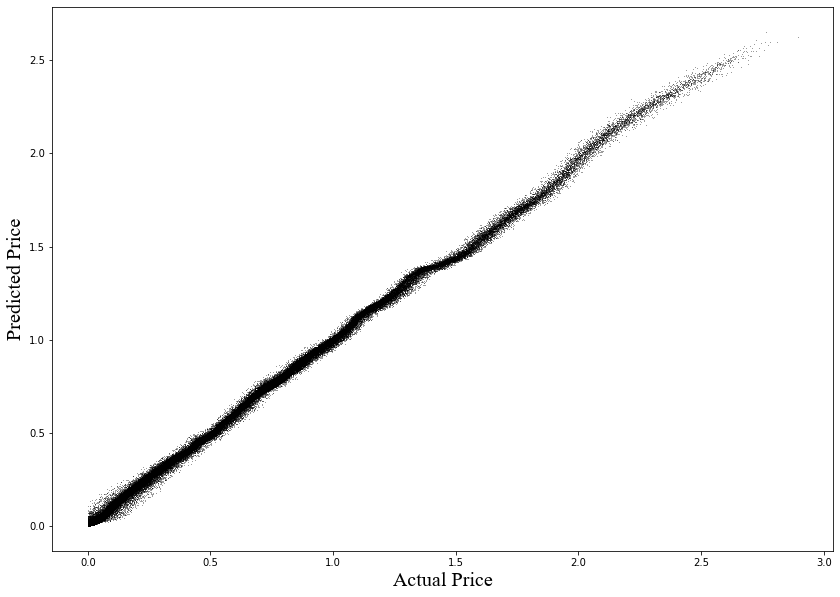

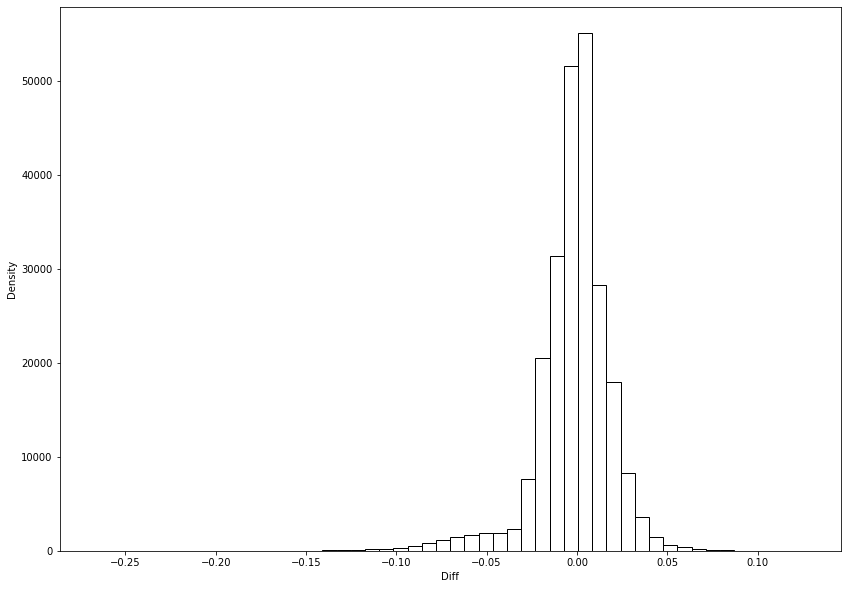

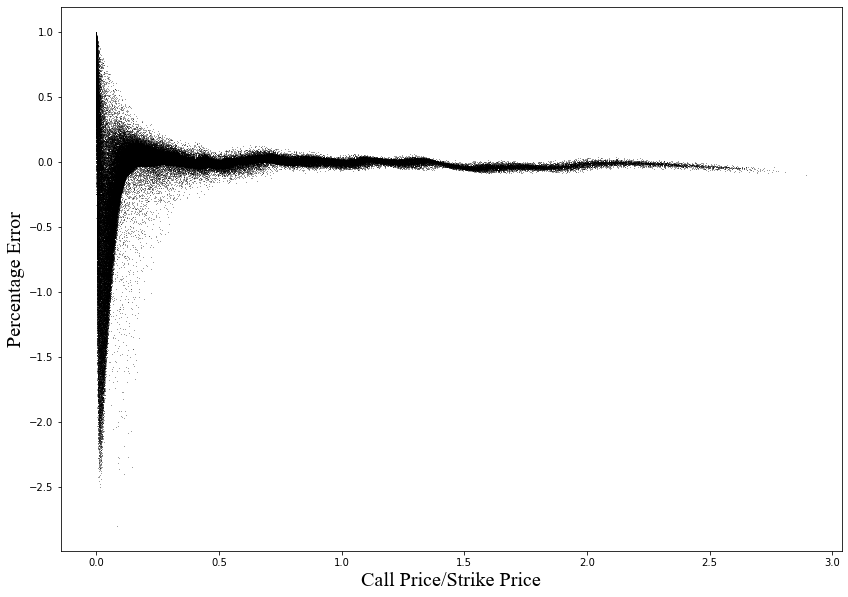

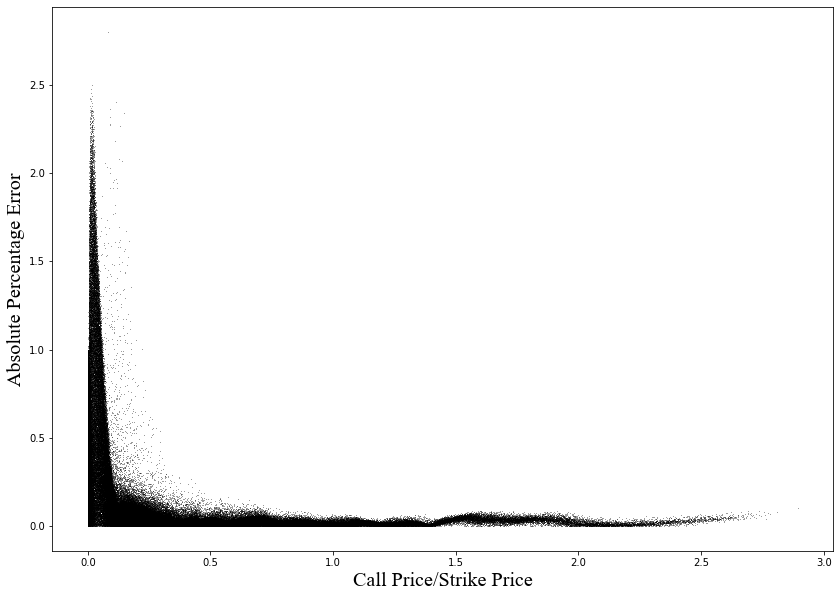

{'diff': array([ 0.00864148, -0.03756982, -0.01049671, ...,  0.02519491,
        -0.01735839,  0.01335907]),
 'mse': 0.00041657667479276506,
 'rmse': 0.020410210062436034,
 'mae': 0.013524919202428242,
 'mpe': 0.05086625608113437}

In [212]:
y_train_hat = model.predict(X_train)
#reduce dim (240000,1) -> (240000,) to match y_train's dim
y_train_hat = np.squeeze(y_train_hat)
CheckAccuracy(y_train, y_train_hat)

Mean Squared Error:       0.00042120547195041057
Root Mean Squared Error:  0.020523290962962314
Mean Absolute Error:      0.013544959218053055
Mean Percent Error:       0.051416580670149946


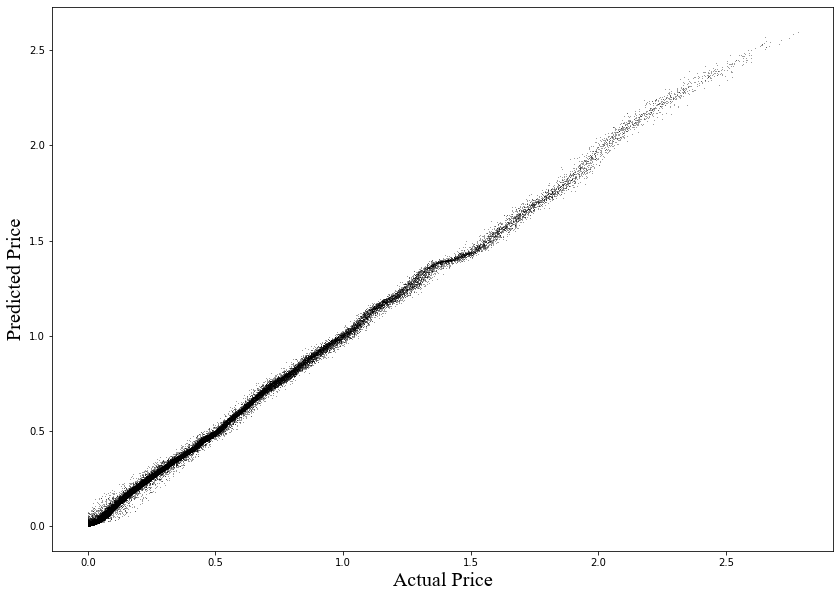

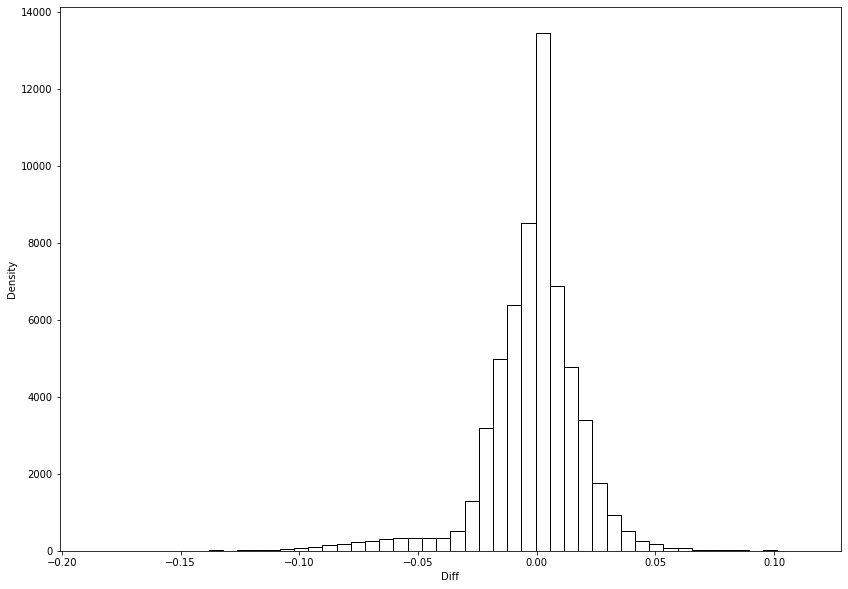

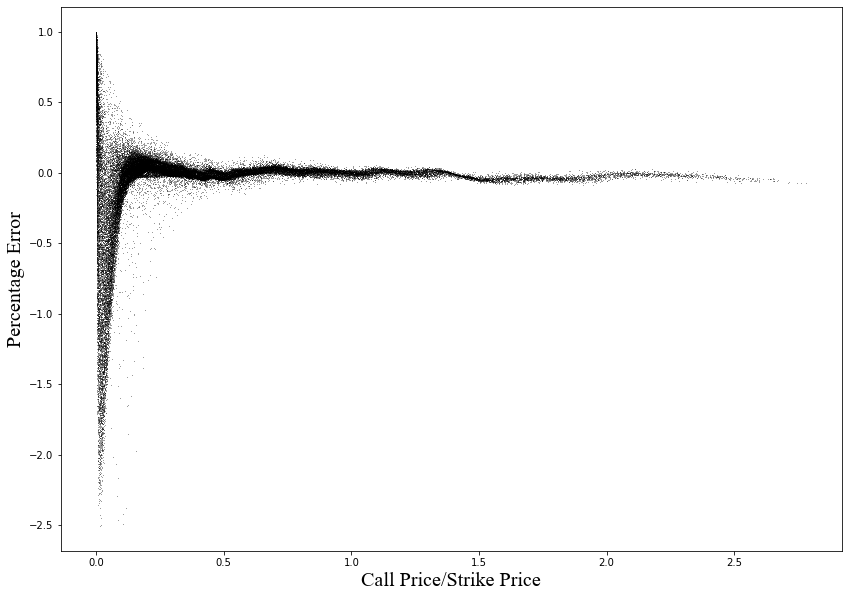

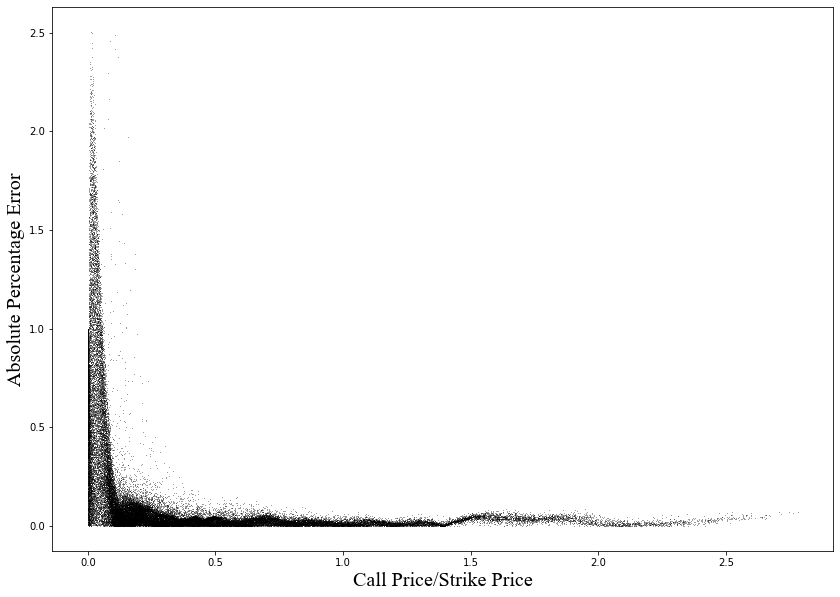

{'diff': array([-0.05513591,  0.00019004,  0.0004865 , ...,  0.01207977,
        -0.01202789, -0.02170601]),
 'mse': 0.00042120547195041057,
 'rmse': 0.020523290962962314,
 'mae': 0.013544959218053055,
 'mpe': 0.051416580670149946}

In [213]:
y_test_hat = model.predict(X_test)
#reduce dim (240000,1) -> (240000,) to match y_train's dim
y_test_hat = np.squeeze(y_test_hat)
CheckAccuracy(y_test, y_test_hat)